# Package Processing

In [171]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# 或是
print(torch.backends.mps.is_available()) # True
print(torch.backends.mps.is_built()) # True

tensor([1.], device='mps:0')
True
True


In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import matplotlib.image as image
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import models
from PIL import Image, ImageFilter
from multiprocessing import Pool
from custom_dataset import ImageDataset



# Data Processing

In [174]:
csv_path = "./nptu-dl-final-project/train.csv"
train_path = "./nptu-dl-final-project/train"

df = pd.read_csv(csv_path).copy()

# print(f"The name of img class {df['label'].unique()}")

# 创建标签映射字典
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
# df['label'] = df['label'].map(label_mapping)
# print(df['label'].dtypes)

print(f"All of the img class {len(np.unique(df['label'].values))}")
df

All of the img class 109


,img_file,label
0,78fbc980fba54a0e98da22352d44e51d.jpg,croquet
1,6c761e579cc542ebbaa9a932c9b22b08.jpg,fencing
2,f475146a31564c929e09f0724af3723b.jpg,sailboat racing
3,bfa1d3e9b6684d43ab81eb836670d942.jpg,gymnastics
4,c42ce1c6a0944b0c86a48950f87bc2fe.jpg,roller derby
...,...,...
15193,54e94178e6384782912b465b48979684.jpg,swimming
15194,bb498eaf088349bb8dd9c3d9431ab702.jpg,cheerleading
15195,4640dabdd97a47b1b26ef6bca583927d.jpg,badminton
15196,2593320dd98d400fbc9e0bab4ca98fc1.jpg,luge


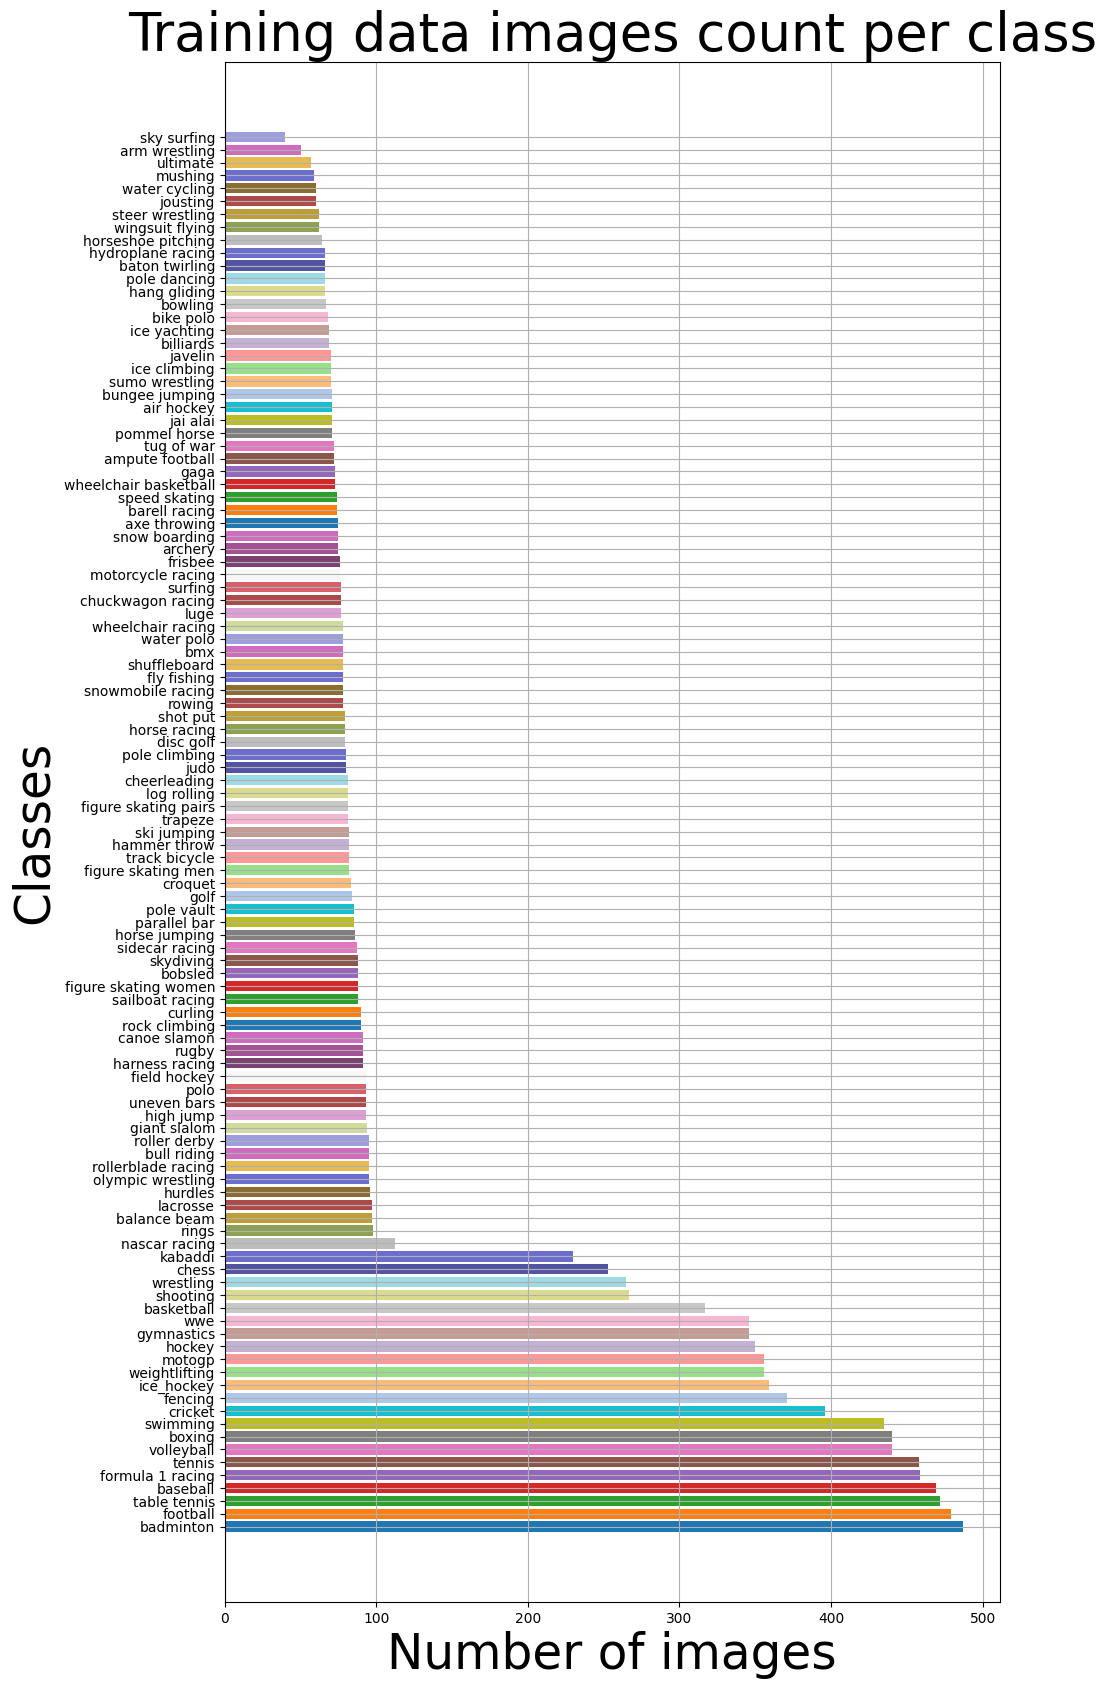

In [175]:
train_data  = df["label"].value_counts()
label = train_data.tolist()
index = train_data.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(10, 20))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

# Image Processing ( including global parameter )

In [176]:
img_height = 224
img_width = 224
INPUT_SHAPE = (img_height, img_width, 3)

BSIZE = 128
L2 = 0.005

EPOCHS = 10
LR = 0.1

In [177]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomRotation(40),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [178]:
from torch.utils.data import Dataset, random_split

train_dataset = ImageDataset(annotations_df=df, root_dir=train_path, transform=train_transform)
print(train_dataset.annotations)
print(len(train_dataset))

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# 使用 random_split 分割数据集
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")

train_dl = DataLoader(train_ds, batch_size=BSIZE, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BSIZE, pin_memory=True)

                                   img_file            label
0      78fbc980fba54a0e98da22352d44e51d.jpg          croquet
1      6c761e579cc542ebbaa9a932c9b22b08.jpg          fencing
2      f475146a31564c929e09f0724af3723b.jpg  sailboat racing
3      bfa1d3e9b6684d43ab81eb836670d942.jpg       gymnastics
4      c42ce1c6a0944b0c86a48950f87bc2fe.jpg     roller derby
...                                     ...              ...
15193  54e94178e6384782912b465b48979684.jpg         swimming
15194  bb498eaf088349bb8dd9c3d9431ab702.jpg     cheerleading
15195  4640dabdd97a47b1b26ef6bca583927d.jpg        badminton
15196  2593320dd98d400fbc9e0bab4ca98fc1.jpg             luge
15197  e4b30e8071424d22939748a85097edb3.jpg           tennis

[15198 rows x 2 columns]
15198
Training set size: 12158
Validation set size: 3040


# Model Construct 

### Sequential

In [179]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 256,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# # model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

### Resnet50

In [180]:
# from torchvision.models import resnet50
# from torchvision import transforms, datasets, models

# resnet50 = models.resnet50(pretrained=True)  # deprecated
# last_layer = nn.Linear(2048, len(np.unique(y_train)))
# resnet50.fc = last_layer
# resnet50

### EfficientNetB1

In [181]:
# base_model =  tf.keras.applications.EfficientNetB1(input_shape = INPUT_SHAPE, # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(base_model)
# model.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

### MobileNetV2 

In [182]:
# base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# tf.keras.backend.clear_session()
    
# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

### MobileNetV3_large

In [183]:
# # 加載預訓練的 MobileNetV3Small 模型
# model = models.mobilenet_v3_small(pretrained=True)

# # 修改模型的最後幾層
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.6),
#     nn.Linear(model.classifier[0].in_features, len(class_names)),
#     nn.Softmax(dim=1)
# )

# # 將模型移動到可用設備（MPS 或 CPU）
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# model = model.to(device)

# # 打印模型結構
# print(model)


In [184]:
# model = tf.keras.applications.MobileNetV3Small(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# net = layers.GlobalAveragePooling2D()(model.output)
# net = Dropout(0.6)(net)
# net = layers.Dense(len(train_generator.class_indices), activation="softmax")(net)

# model = Model(inputs=model.inputs,outputs=net)
# model.summary()

### Other

In [185]:
import timm
from timm.loss import LabelSmoothingCrossEntropy

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=100)

# model.head = nn.Sequential(
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, class_len)) # Modify head according to this task

model = model.to(device)

criterion = LabelSmoothingCrossEntropy() # this is better than nn.CrossEntropyLoss
criterion = criterion.to(device)

optimizer = torch.optim.AdamW(model.head.parameters(), lr=LR) # Setting for transfer learning

In [186]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

# Callback

# Training

In [187]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [188]:
model.train()

total_step = len(train_dl)
curr_lr = LR
best_score = 0
for epoch in range(EPOCHS):
    total_loss = 0
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        
        g_labels = model(images)
        
#         g_labels = rearrange(g_labels, 'b x y dim -> b dim (x y)', x=7, y=7)
#         g_labels = g_labels[:, :, 0]
#         g_labels = torch.squeeze(g_labels, 1)
        
        # print(g_labels.shape)
        # print(labels.shape)
        # print(int(torch.max(g_labels, 1)[1][0] == labels[0]))
        
        loss = criterion(g_labels, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(BSIZE*(i+1), train_dataset.__len__()))
            
    model.eval()
    score = 0
    for i, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        labels = labels.to(device)

        g_labels = model(images)
        
#         g_labels = rearrange(g_labels, 'b x y dim -> b dim (x y)', x=7, y=7)
#         g_labels = g_labels[:, :, 0]
#         g_labels = torch.squeeze(g_labels, 1)

        score += int(torch.max(g_labels, 1)[1][0] == labels[0])
        
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
    avg = score / len(val_dl)
    print('Accuracy: {:.2f}\n'.format(avg))
    model.train()
    
        
    if (epoch+1) % 2 == 0:
        curr_lr = curr_lr * 0.8
        update_lr(optimizer, curr_lr)

RuntimeError: index 105 is out of bounds for dimension 1 with size 100

# Evaluate

In [ ]:
scores  = model.evaluate(validation_generator)
scores

95/95 [==============================] - 7s 76ms/step - loss: 2.7622 - accuracy: 0.3682


[2.762213706970215, 0.3682132363319397]

In [ ]:
print(f"Root mean squared error: {scores[0]:.4f}")
print(f"Test accuracy: {scores[1]:.2%}")

# Visualization

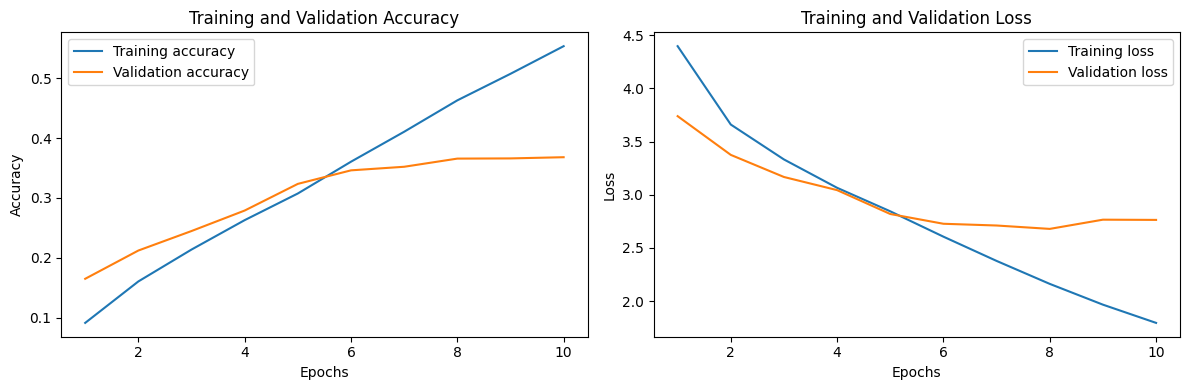

In [ ]:
def visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies):
    """
    Function to plot the losses and accuracies
    """
    
    fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title("Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title("Accuracy")
    axes[1].grid()

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
visualize_results(train_loss, train_acc, val_loss, val_acc)

In [ ]:
# image2_path = "/kaggle/input/nptu-dl-final-project/test/0017b4ce9b9f48309a6986aea4a1aaa7.jpg"
# image2 = image.imread(image2_path)
# plt.imshow(image2)
# plt.axis(False)
# plt.show()

# image2.shape

# Result

In [ ]:
test_path = "./nptu-dl-final-project/test"
test_datagen = ImageDataGenerator(rescale=1./255)

# 獲取所有圖像文件名稱
test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# 創建 DataFrame
df_test = pd.DataFrame({
    'img_file': test_filenames,
    'label': ['unknown'] * len(test_filenames)  # 這裡的label隨意填寫，因為我們不會用到
})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='img_file',
    y_col=None,  # 沒有標籤
    target_size=(img_height, img_width),
    batch_size=BSIZE,
    class_mode=None,  # 沒有標籤
    shuffle=False  # 保持文件順序
)

# 預測
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 獲取文件名
filenames = test_generator.filenames
filenames = [f.split('/')[-1] for f in filenames]  # 只保留文件名

In [ ]:
predicted_labels = [class_indices[int(k)] for k in predicted_classes]
results = pd.DataFrame({
    'img_file': test_filenames,
    'label': predicted_labels
})

# 保存到 .csv 文件
# results.to_csv('/kaggle/working/results.csv', index=False)
results.to_csv('/content/results.csv', index=False)

### Test

In [ ]:
import torchvision

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 创建数据集
train_dataset = CustomDataset(csv_file=csv_path, root_dir=train_path, transform=transform)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 定义模型
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 109)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 这里不再需要手动转换标签为 one-hot 编码
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion
        optimizer.step()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss))

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]